# Customer Data Analysis and Clustering

This notebook aims to analyze and cluster data of clients from a wholesale distributor using techniques such as Principle Component Analysis and k-means clustering.

The data is fetched from the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/wholesale+customers). Visit the Github repository of the project at [github.com/quan-possible/segmentation](https://github.com/quan-possible/segmentation).

Author: [Bruce Nguyen](https://github.com/quan-possible)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA,KernelPCA
from sklearn.cluster import KMeans

plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')

## Table of Contents
1. [Data Cleaning](#1.)
2. [Exploratory Data Analysis](#2.)
3. [Principle Component Analysis (PCA)](#3.)
4. [Kernel Principle Component Analysis (KPCA)](#4.)
5. [Clustering](#5.)

## Data Cleaning <a class="anchor" id="1."></a>

We start by reading the data and getting familliar with it.

In [2]:
df = pd.read_csv('Wholesale customers data.csv')
df

Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  
0          1338  
1          1776  
2          7844  
3          1788  
4          5185  
..          ...  
435        2204  
436        2346  
437        1867  
438        2125  
439          52  

[440 rows x 8 columns]

To have more informative categorical variables, the numbering in variables `Channel` and `Region` was substituted by their actual meaning in the description of the dataset. 

In [3]:
df = df.rename(columns={'Delicassen': 'Delicatessen'})
df['Channel'] = df['Channel'].map({1:'HoReCa', 2: 'Retail'})
df['Region'] = df['Region'].map({1:'Lisbon', 2: 'Porto',3:'Other'})
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicatessen'],
      dtype='object')

In [4]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel           440 non-null    object
 1   Region            440 non-null    object
 2   Fresh             440 non-null    int64 
 3   Milk              440 non-null    int64 
 4   Grocery           440 non-null    int64 
 5   Frozen            440 non-null    int64 
 6   Detergents_Paper  440 non-null    int64 
 7   Delicatessen      440 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 27.6+ KB
None


Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

Well, looks like the data is clean enough with no missing value! All we need to do left is to save it for future uses.

In [5]:
df.to_csv("wholesale-processed.csv")

## Exploratory Data Analysis <a class="anchor" id="2."></a>

We can see that there are 2 types of feature in this dataset: categorical and continuous. Let's create lists to keep track of them.

In [6]:
continuous = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicatessen']
categorical = ['Channel','Region']
print(str(continuous) + '\n length: ' + str(len(continuous)))
print(str(categorical) + '\n length: ' + str(len(categorical)))

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']
 length: 6
['Channel', 'Region']
 length: 2


Now, we can start exploring! We can begin by looking into the categorical features first for logicalness.

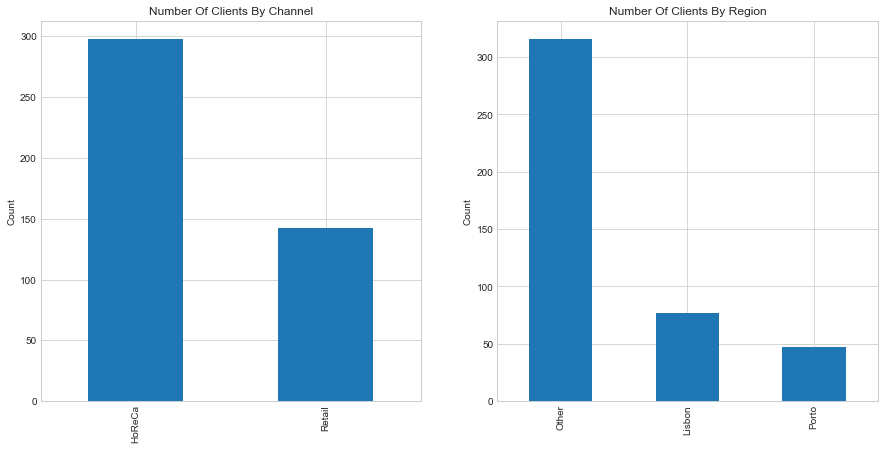

In [7]:
f,ax=plt.subplots(1,2,figsize=(15,7))
df['Channel'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number Of Clients By Channel')
ax[0].set_ylabel('Count')
df['Region'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('Number Of Clients By Region')
ax[1].set_ylabel('Count')
plt.show()

By first taking a sanity check, we can see that there is a healthy number of counts in all the categories. Looking at the first plot more closely, it is visible that the HoReCa (Hotels/Restaurants/Cafes) channel is used by a lot more customers compared to the other one. Concerning the regions, a big number of the orders does not record their name, leaving us with a substantial number of 'Other' category. Moving on, how about we combine both of the 2 features together?

In [8]:
count = df.groupby(["Region","Channel"])["Channel"].count().unstack()
count.style.background_gradient(cmap='viridis')

<AxesSubplot:xlabel='Region', ylabel='count'>

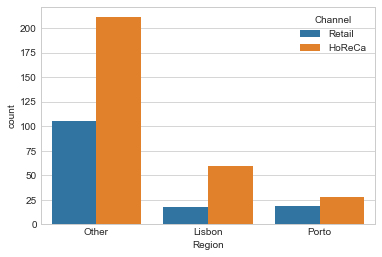

In [9]:
sns.countplot(x='Region',hue='Channel',data=df)

In the new plot, not much changed about the relative quantities of the categories. That's it for those 2 features. We now move on to the more important part - analysing the numbers! A good start is to plot them all at once and have a preliminary check of their distributions.

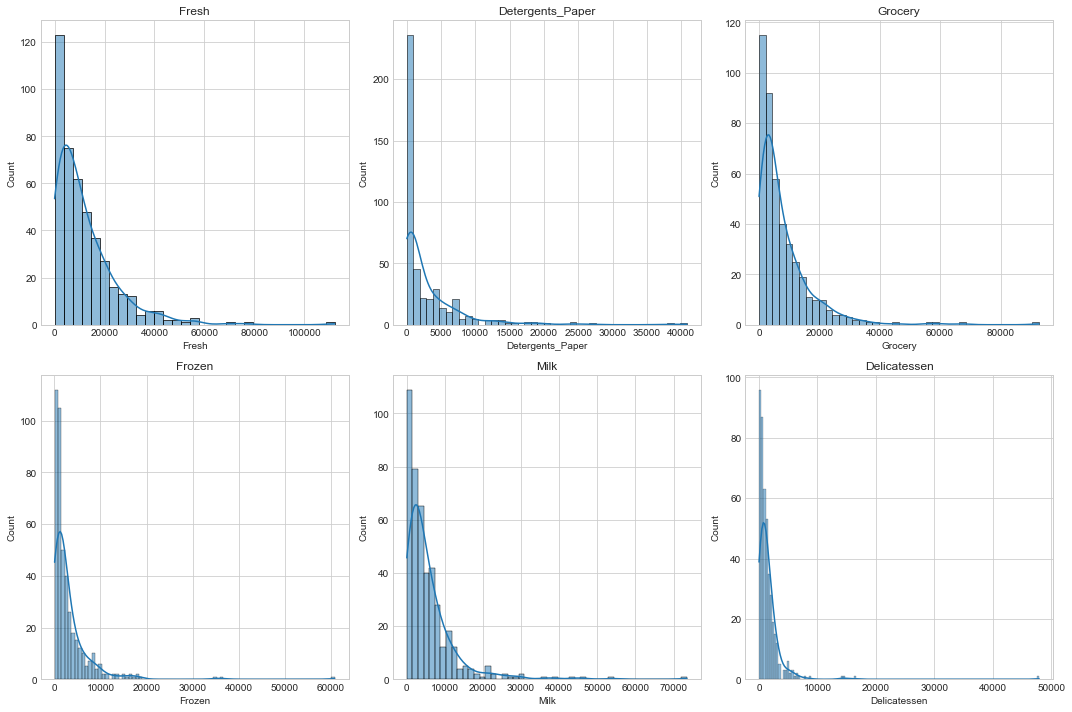

In [10]:
f,ax = plt.subplots(2,3,figsize=(15,10))

for i,fea in enumerate(continuous):
    r,c = i%2,i%3
    sns.histplot(df[fea],ax=ax[r,c],kde=True)
    ax[r,c].set_title('{}'.format(fea))
    
plt.tight_layout()
plt.show()

We can see that all of the quantities follow a shape akin to the Chi-squared distribution, with most of the value centered at 0. That said, to have a better understanding of the relative difference, we should put them in the same plot on a single scale. This can be done by using violin plots.

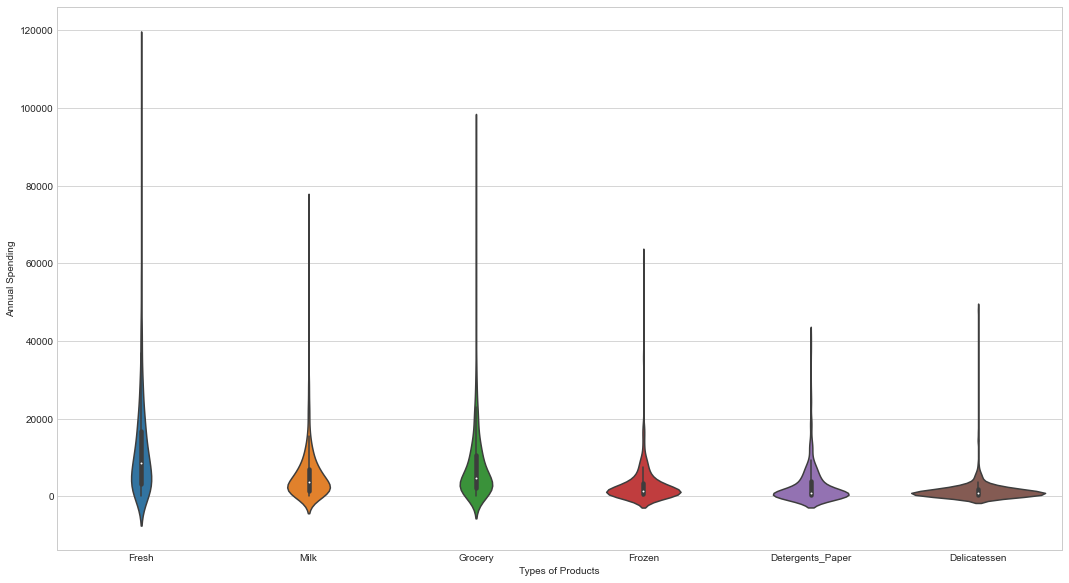

In [11]:
melted = df[continuous].melt(var_name='Types of Products', value_name='Annual Spending')
plt.figure(figsize=(18, 10))
ax = sns.violinplot(x='Types of Products', y='Annual Spending', data=melted)
# _ = ax.set_xticklabels(df[continuous].keys(), rotation=90)

Looks great! Now we know that `Delicatessen` has the sharpest peak in terms of distribution of them all, while `Fresh` has fatter tails than the rest of the features. To investigate the relationship between different continuous features, we can do pair plots of between each of them. This way, we might even get a hint of what kind of clusters we are going to get. 

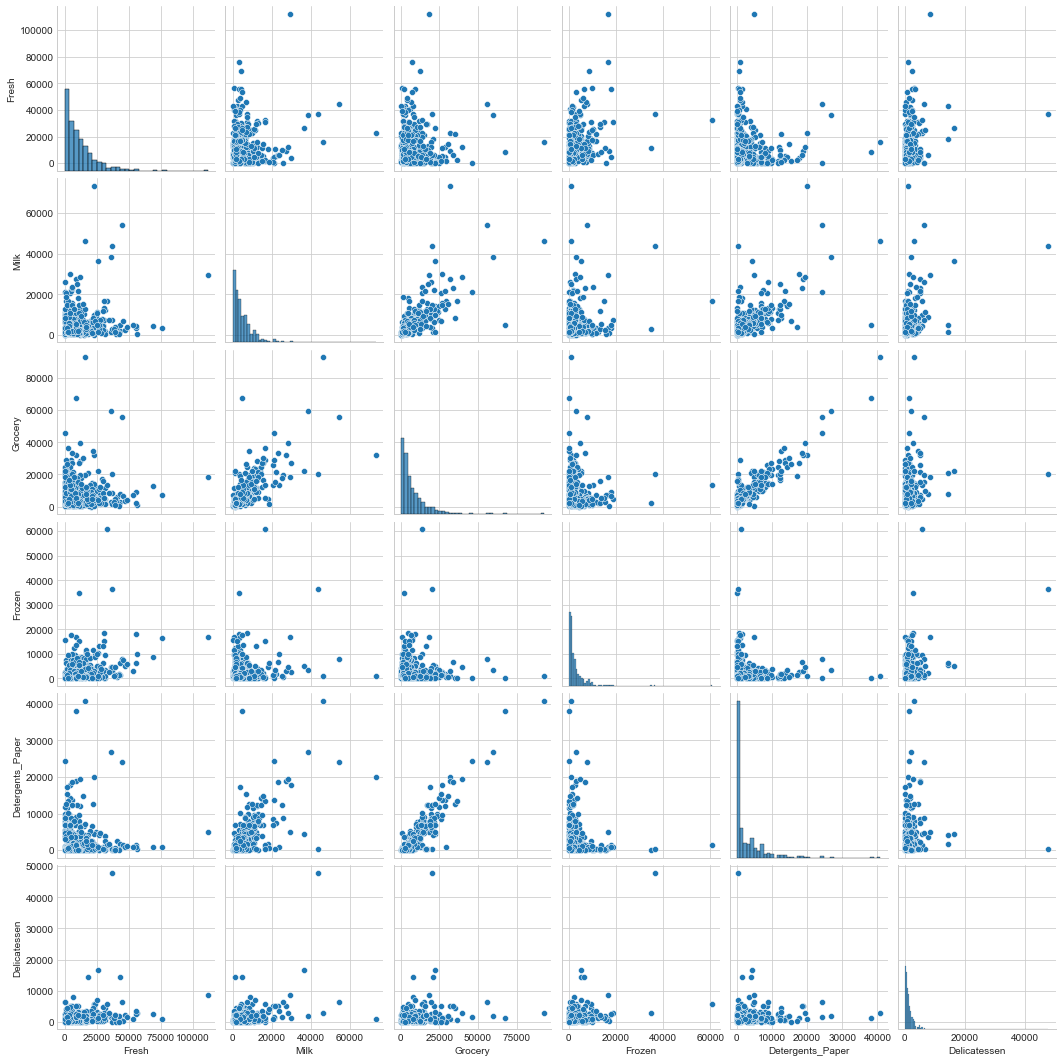

In [12]:
sns.pairplot(df)

Overall, there is not much correlation between the features, with the exception of `Grocery` and `Detergents_Paper`. However, we can go even one step further by plotting the pairs along with the labels from categorical variables. All it takes is another single line of code. 

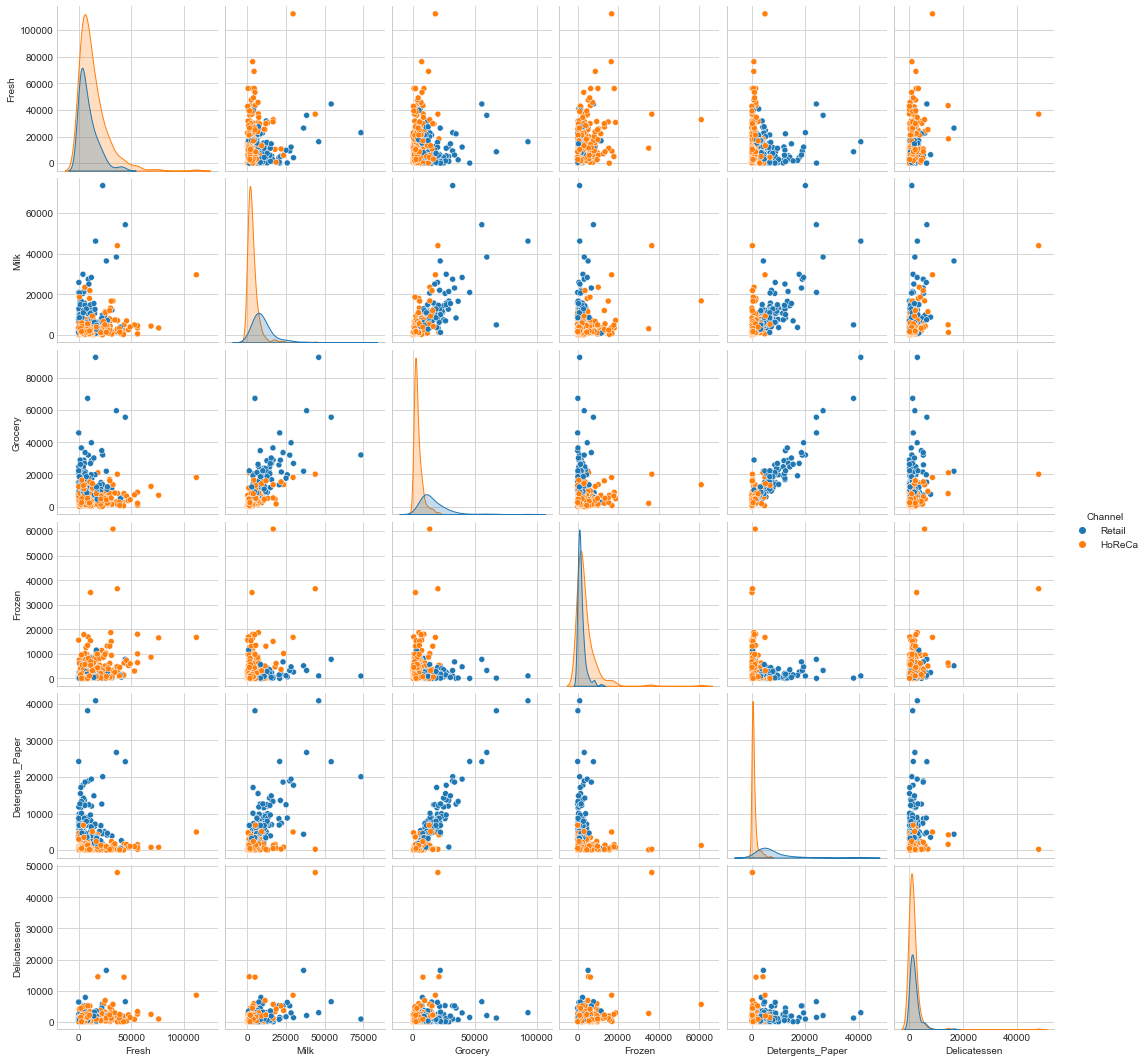

In [13]:
sns.pairplot(df,hue='Channel')

We can immediately see a lot of interesting details, with clusters forming in many scatter plots. Notably, `Retail` customers buy far more `Detergents_Paper` in Dollars compared to `HoReCa` ones, with the feature being able to segment the two categories nicely. The same thing can be said with regards to `Grocery`, however, to a lesser extent. Overall, there are a lot of difference between the two type of customers, which should be taken note of from a business perspective. 

We move on to also plotting the continuous features against the categories within `Region`. 

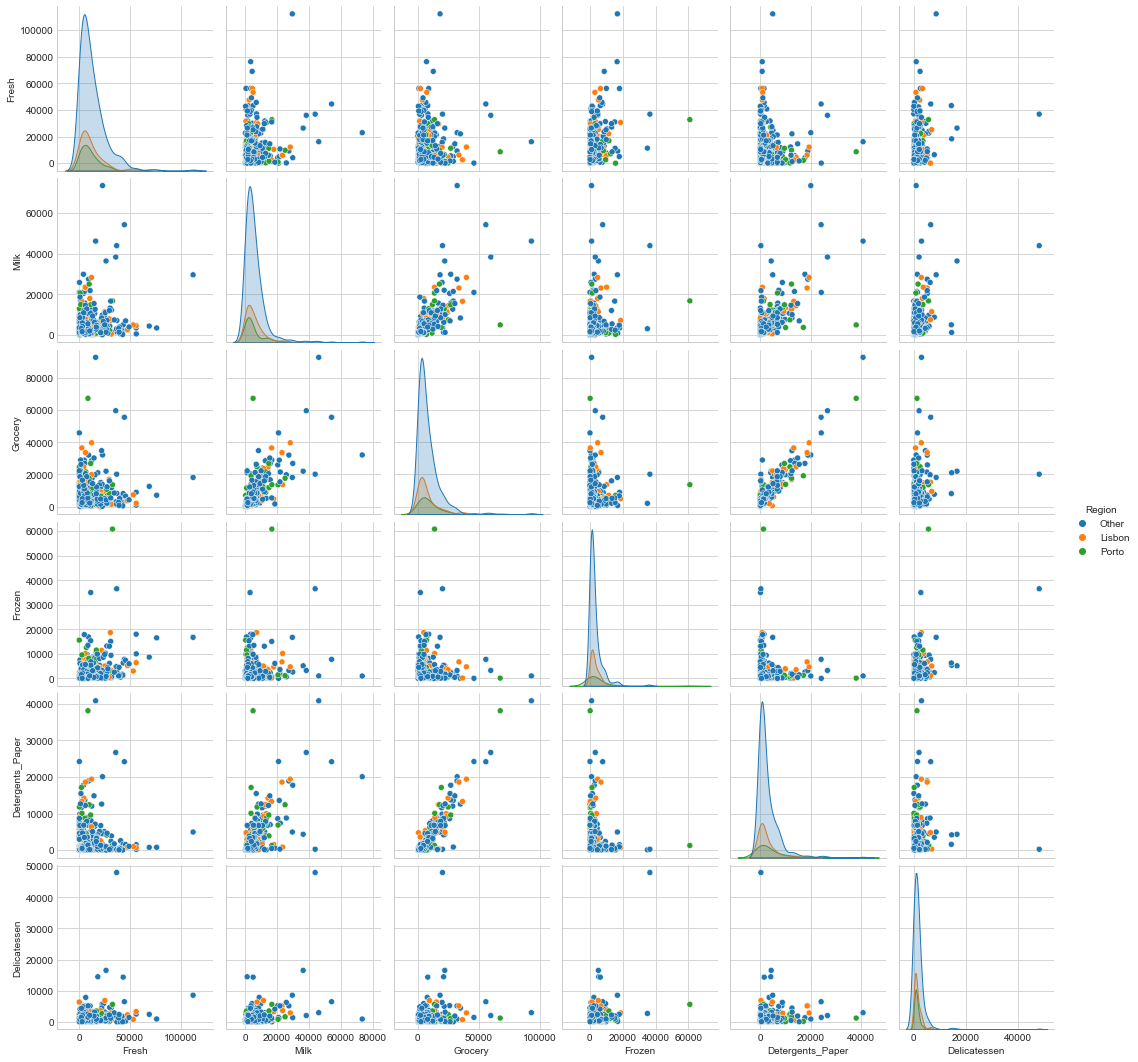

In [14]:
sns.pairplot(df,hue='Region')

Unfortunately, there is apparently not much variability between the different categories in `Region` along all the features. However, we need to dive further in the analysis before coming to any conclusion.

With the exploratory analysis out of the way, we move on to actually clustering the data.

## Principle Component Analysis (PCA) <a class="anchor" id="3."></a>

Before applying any clustering algorithm, we first need to reduce the number of dimensions in the data. This is because in dimensions, the performance of many classical machine learning algorithms drop significantly, and the need for computational resources increase exponentially ("curse of dimensionality")

The PCA process reduces the number of dimensions by computing the principal components that explain the most variance in data. Think of it as a photographer trying to find the best angle to capture a picture of a group of people, reducing the number of dimensions while minizing the loss of information (Of course the angle is in front of the group!).

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scaling
df_scaled = df[continuous].to_numpy()
df.shape

(440, 8)

We need to scale the data before hand so that every feature has an equal effect on the analysis.

In [16]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_scaled)
df_scaled

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

An ad hoc test is then used to find the smallest number of components that still capture most of the data. This works by plotting the cumulative amount of variance explained by progressively higher number of components.

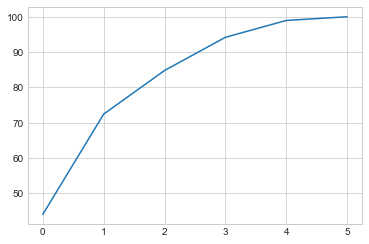

In [17]:
pca = PCA(n_components = 6)
pca.fit(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))

Here, we choose to use 4 components, as there is not much more to gain by using more according to the plot. After this, it is simply about fitting the data and computing the components! 

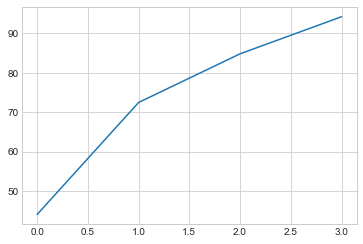

In [18]:
pca = PCA(n_components = 4)
res_pca = pca.fit_transform(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))

We can see that our components explain up to 95% amount of the variance in data, which means we have saved a lot of information. Next, the relationship between the new components and the original features can be visualized using scatterplots. Just for convenience, I only use the first 2 principle components.

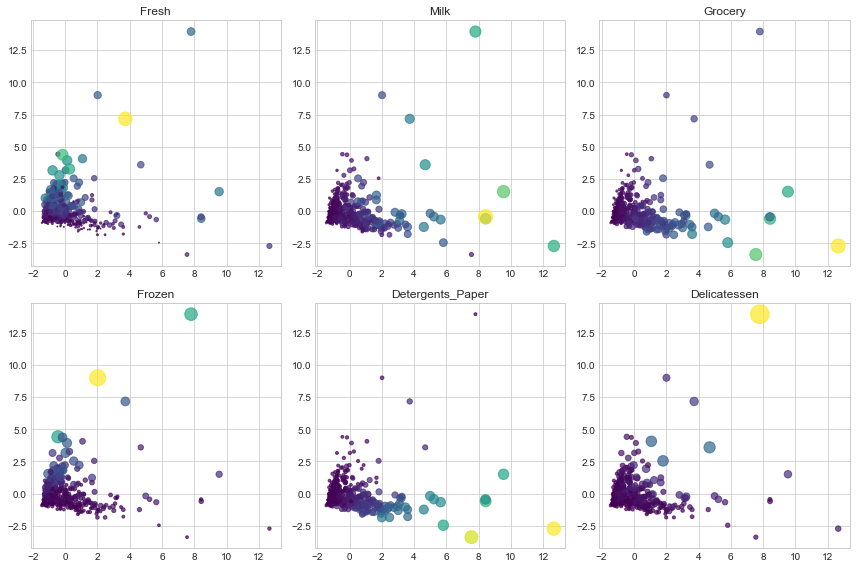

In [19]:
fig,axes = plt.subplots(2,3,figsize = (12,8))
const = 20 # make the dots more visible

for fea,ax in zip(continuous,axes.ravel()):
    sizes = const + const * df_scaled[:,continuous.index(fea)] # magnitude in scaled data
    colors = df[fea] # magnitude in original data 
    ax.scatter(res_pca[:,0], # x axis is 1st component
               res_pca[:,1], # y axis is 2nd component
               alpha=0.7,s=sizes, c=colors, cmap = 'viridis')
    ax.set_title(fea)
    
plt.tight_layout()

Looking at the plots, we can see some very interesting 'directions' for the change in data. Take the `Fresh` and `Frozen` plots as an example, the colors and the sizes here change mostly along the y axis, showing that the 2nd principle component explains more of the variance in magnitude of these 2 features. On the other hand, the `Detergents_Paper` and `Grocery` plots sees most of its changes lying along the x-axis, showing that it is better described by the first component.

We can also check how the components relate to the `Chanel` and `Region` categorical variables. In a way, PCA is also a clustering method, as the most dominant patterns that separate groups are usually captured by PCA, especially within the first component. Nevertheless, we need to plot these features against the value of the components to find out.

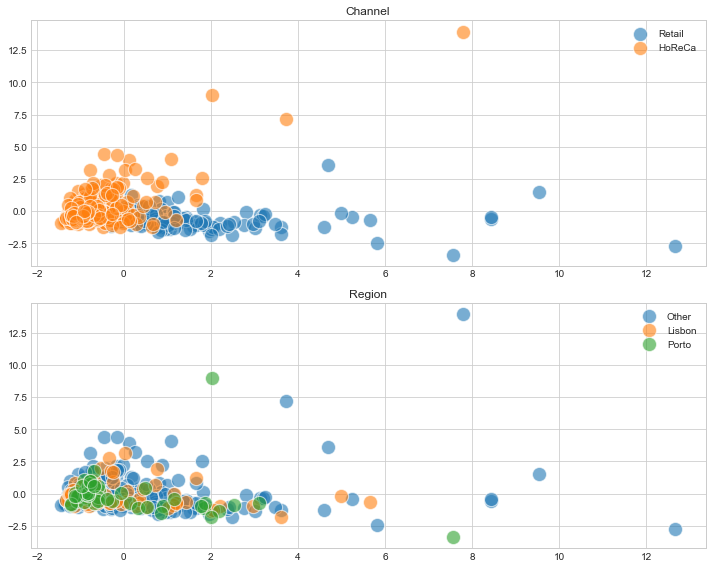

In [20]:
fig,axes = plt.subplots(2,1, figsize = (10,8))
const = 200

for feature,ax in zip(categorical,axes.ravel()):
    for unique_val in df[feature].unique(): # unique_val is unique values in the categorical features 
        sns.scatterplot(x=res_pca[df[feature] == unique_val,0],
                        y=res_pca[df[feature] == unique_val,1],
                       alpha= 0.6,label=unique_val,s=const, ax=ax)
        ax.set_title(feature)
        
plt.tight_layout()

In the first chart, it can already be seen that the first principle component manages to separate the values labeled `Retail` with those from `HoReCa`. In the second plot, things do not go that smoothly with the regions, with values from the 3 categories still clustering together.

For even more information, we add another dimension to our plot - the 3rd component - and see how much information the new component can give us visually.

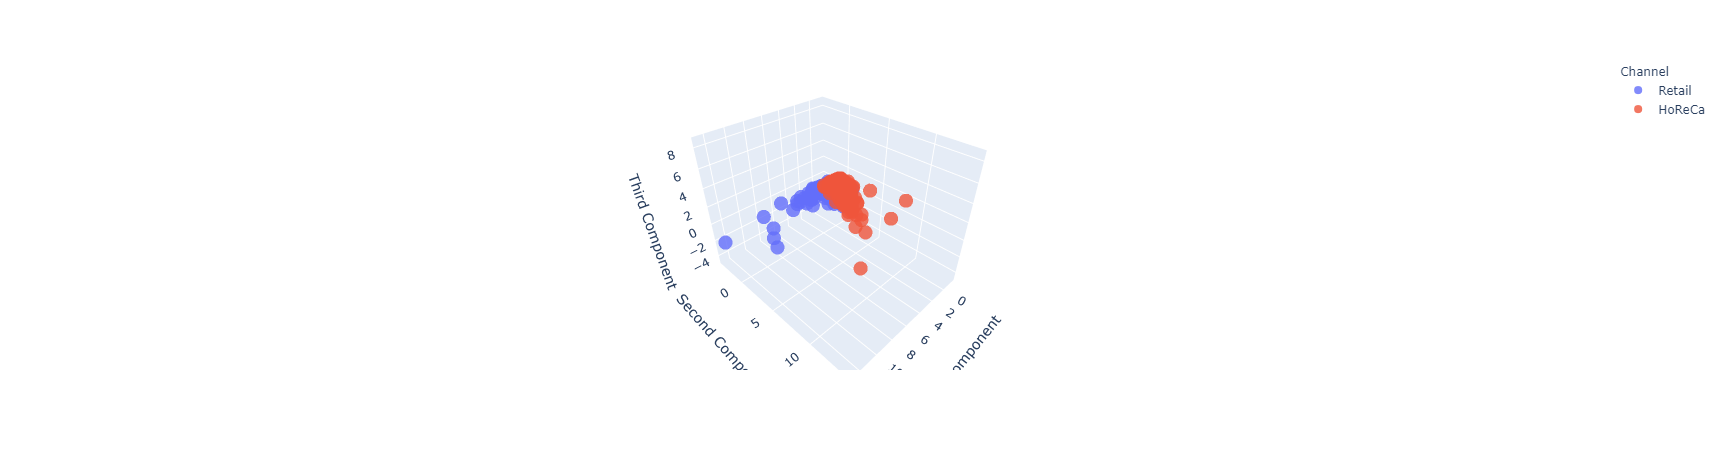

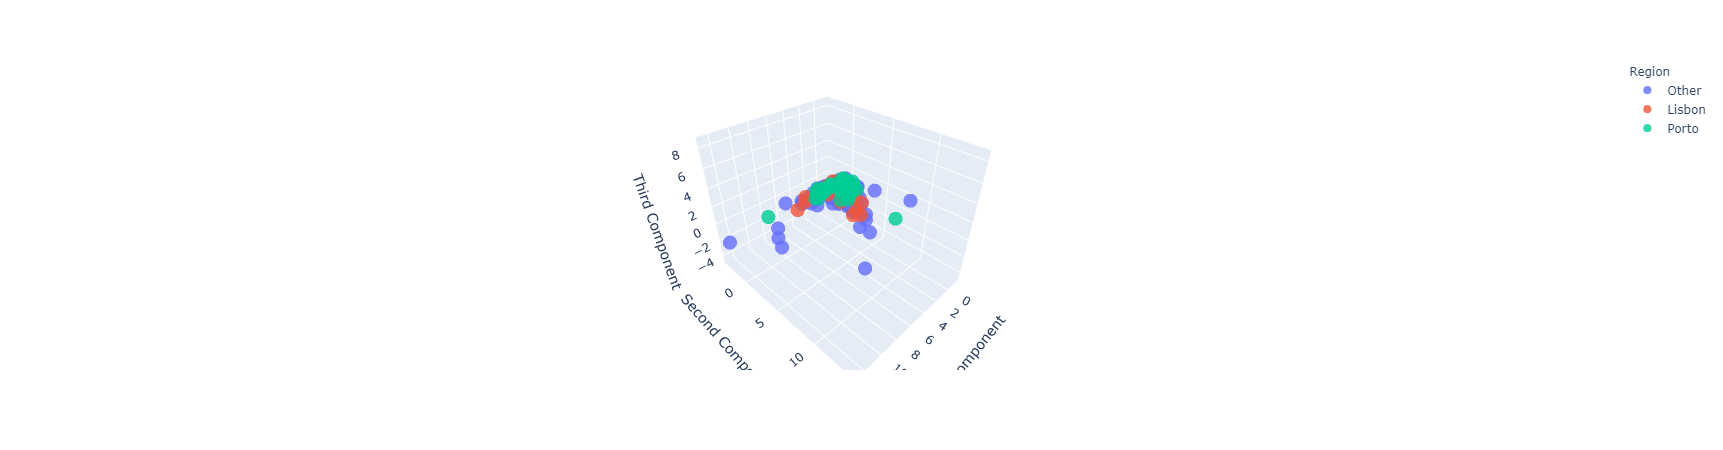

In [21]:


for feature,ax in zip(categorical,axes.ravel()):
    sizes = const
    temp = pd.concat([pd.DataFrame(res_pca,columns= ['First component','Second Component',
                                                     'Third Component','Fourth Component']),
                        df[feature]], axis=1)
    fig = px.scatter_3d(temp, x='First component',
                        y='Second Component',
                        z='Third Component',
                       color = temp[feature],opacity=0.8)
    fig.show()

The 3D space surely looks more intuitive and fun to play with! However, there are not much improvement in the new plots over the 2D ones regarding the task of clustering itself.

From the 4 plots, we can see that there is a significant holistic difference in customer spending between the categories of `Channel`, further confirming our initial assumption. On the other hand, there is, unsurprisingly, not much variability between the customers coming from different regions, contradicting the wide-spread assumption in the business world.

That said, I believe that we can go even further by employing a more advanced technique: Kernel Principal Component Analysis.

## Kernel Principal Component Analysis (KPCA) <a class="anchor" id="4."></a>

KPCA extends PCA by using a kernel (function) by giving us access to higher dimensions without the complications that follows. Besides the process of computing the components itself, this section repeats many of the steps from the last one.

In [22]:
kpca = KernelPCA(n_components=4,kernel='rbf')
res_kpca = kpca.fit_transform(df_scaled)

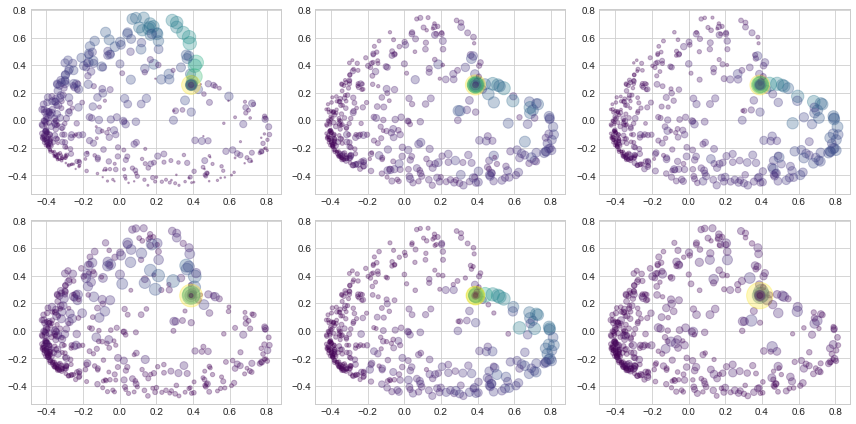

In [23]:
fig,axes = plt.subplots(2,3,figsize=(12,6))
const = 40

for feature,ax in zip(continuous,axes.ravel()):
    sizes = const + const * df_scaled[:,continuous.index(feature)]
    ax.scatter(res_kpca[:,0],res_kpca[:,1],
               s=sizes,alpha=0.3, c = df[feature],cmap='viridis')
    
plt.tight_layout()

We can already see that the direction of changes in value has become very non-linear, and the data has become much more scattered.

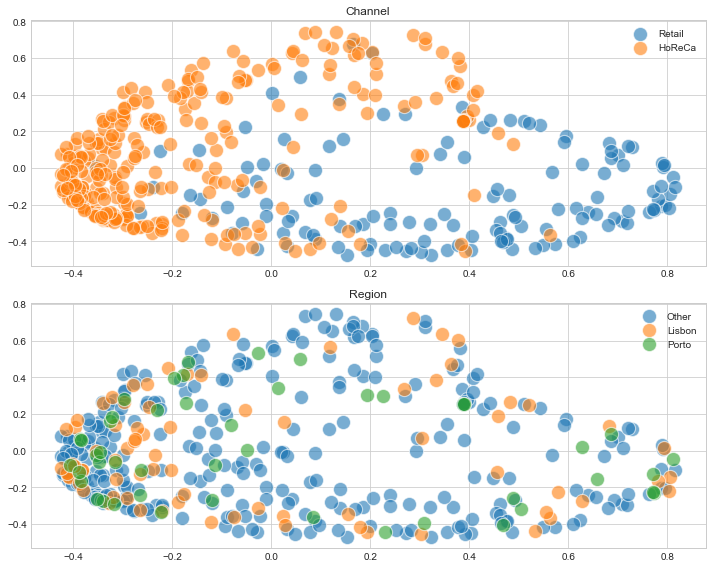

In [24]:
fig,axes = plt.subplots(2,1, figsize = (10,8))
const = 200

for feature,ax in zip(categorical,axes.ravel()):
    for unique_val in df[feature].unique():
        sns.scatterplot(x=res_kpca[df[feature] == unique_val,0],
                        y=res_kpca[df[feature] == unique_val,1],
                       alpha=0.6,label=unique_val,s=const, ax=ax)
        ax.set_title(feature)
        
plt.tight_layout()

In this new space, the data looks comparatively more separated by categories, especially with regards to `Channel`. However, the separation is still not very satisfactory, and I can feel the need for an extra dimension. In the other feature, the situation remains the same.

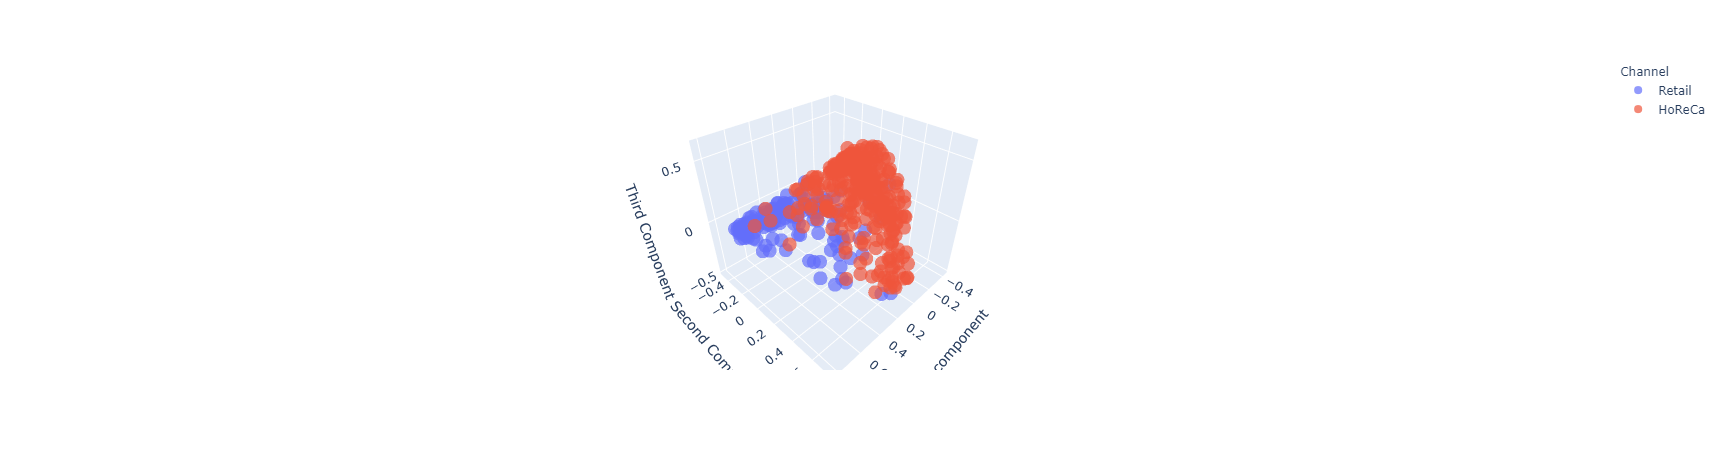

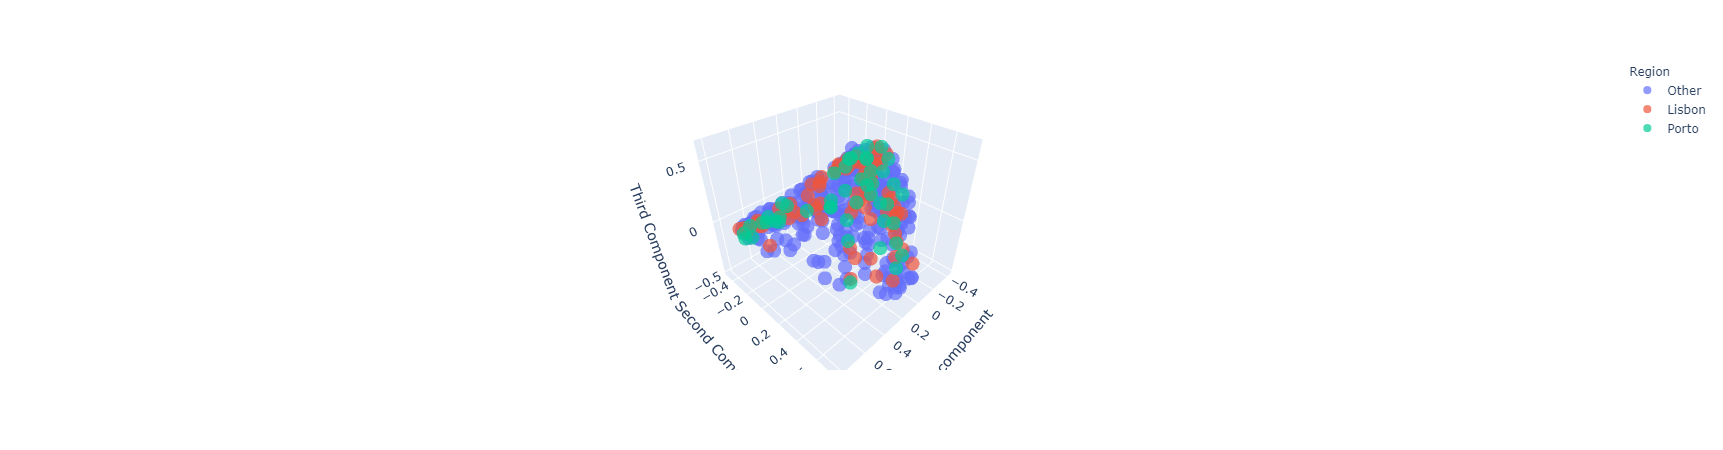

In [25]:
import plotly.express as px

for feature,ax in zip(categorical,axes.ravel()):
    sizes = 200
    temp = pd.concat([pd.DataFrame(res_kpca,columns= ['First component','Second Component',
                                                     'Third Component','Fourth Component']),
                        df[feature]], axis=1)
    fig = px.scatter_3d(temp, x='First component',
                        y='Second Component',
                        z='Third Component',
                       color = temp[feature], opacity=0.7)
    fig.show()

Both of these plots look much better than the ones before. Thus, I choose to perform clustering on the KPCA values in order to generate the best results. This way, the principal components becomes the **latent variable** that is fed into the clustering algorithms. All we need to do now is to save the values into the data frame and create a new .csv file - for good measure.

In [26]:
df_latent = df.copy()
df_latent['kpca_1'],df_latent['kpca_2'] = res_kpca[:,0],res_kpca[:,1]
df_latent['kpca_3'],df_latent['kpca_4'] = res_kpca[:,2],res_kpca[:,3]
df.to_csv('wholesale-latent.csv')

## Clustering <a class="anchor" id="5."></a>

In this project, we will use the k-means clustering algorithm. The algorithm works by finding $k$ centers, one for each cluster, by minimizing within-cluster variances. However, before actually using the algorithm, we need to find the right number of clusters, the right $k$, by using another elbow test.

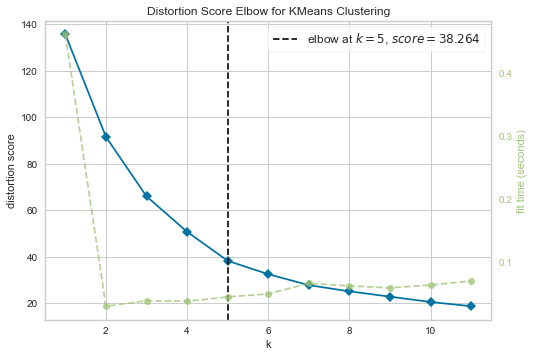

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
from yellowbrick.cluster import KElbowVisualizer # Instantiate the clustering model and visualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(res_kpca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The diagnostics points us towards using 5 clusters, and our task now is simply clustering the data with that parameter. 

In [28]:
clusterer = KMeans(n_clusters=5)
clusters = clusterer.fit_predict(res_kpca)
clusters = pd.Series(clusters,name='Cluster_No')
clusters

0      3
1      3
2      1
3      0
4      4
      ..
435    1
436    4
437    1
438    2
439    2
Name: Cluster_No, Length: 440, dtype: int32

In [29]:
combined = pd.concat([df_latent,clusters],axis=1)
combined

Channel Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0    Retail  Other  12669   9656     7561     214              2674   
1    Retail  Other   7057   9810     9568    1762              3293   
2    Retail  Other   6353   8808     7684    2405              3516   
3    HoReCa  Other  13265   1196     4221    6404               507   
4    Retail  Other  22615   5410     7198    3915              1777   
..      ...    ...    ...    ...      ...     ...               ...   
435  HoReCa  Other  29703  12051    16027   13135               182   
436  HoReCa  Other  39228   1431      764    4510                93   
437  Retail  Other  14531  15488    30243     437             14841   
438  HoReCa  Other  10290   1981     2232    1038               168   
439  HoReCa  Other   2787   1698     2510      65               477   

     Delicatessen    kpca_1    kpca_2    kpca_3    kpca_4  Cluster_No  
0            1338  0.078374 -0.173115 -0.338646  0.125439           3  
1            1776  0.185813 -0.307415 -0.189365  0.244399           3  
2            7844  0.341702  0.075048  0.065402  0.055788           1  
3            1788 -0.253304  0.250352  0.159350  0.322670           0  
4            5185  0.136617  0.375279 -0.206154  0.208622           4  
..            ...       ...       ...       ...       ...         ...  
435          2204  0.376162  0.466779  0.244987  0.119531           1  
436          2346  0.130231  0.745111 -0.197829 -0.150616           4  
437          1867  0.720747  0.122400  0.271172 -0.372950           1  
438          2125 -0.352004 -0.033909 -0.078534 -0.070619           2  
439            52 -0.343427 -0.268287  0.101947 -0.254443           2  

[440 rows x 13 columns]

All is good so far! Now is the moment the numbers turn in to geometric shapes. First we plot the clusters against the `Fresh`,`Milk` and `Grocery` values as well as the `Channel` feature.

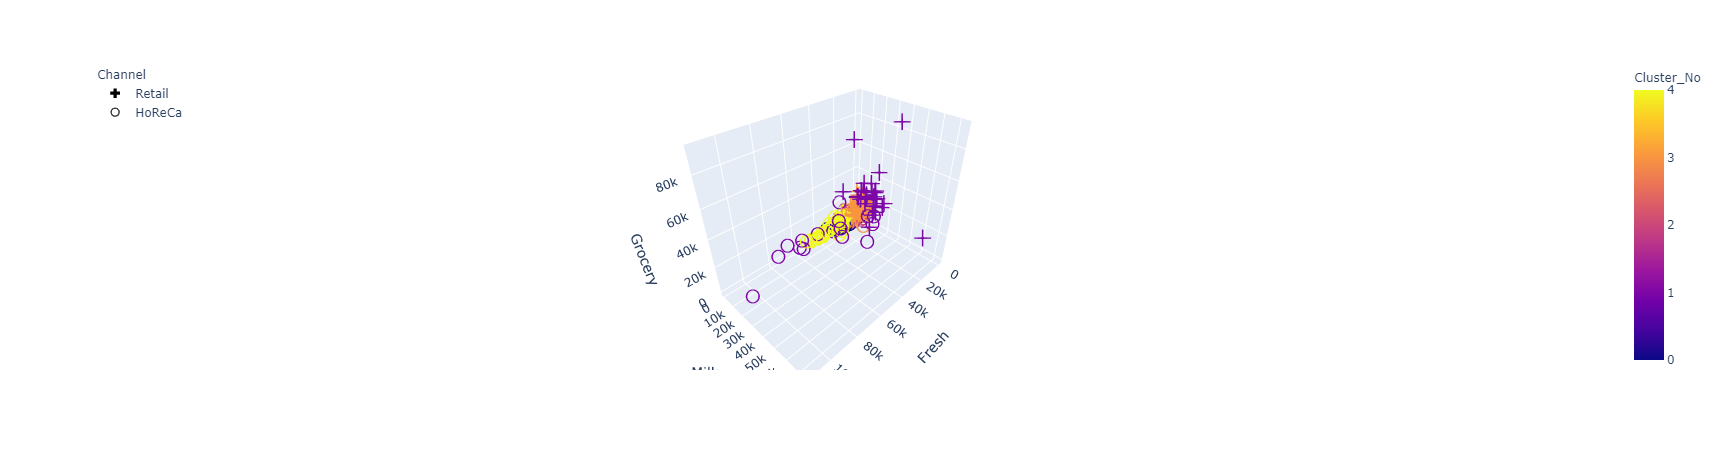

In [30]:
fig = px.scatter_3d(combined, x='Fresh',y='Milk',z='Grocery',
                   symbol='Channel',color = 'Cluster_No')

# specify trace names and symbols in a dict
symbols = {'Retail': 'cross',
           'HoReCa':'circle-open'}

# set all symbols in fig
for i, d in enumerate(fig.data):
    fig.data[i].marker.symbol = symbols[fig.data[i].name]

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

Even though the clusters separate the values along these variables to some extent, the segmentation is not exactly clear-cut along the lines. Now comes the same plot but with the features `Frozen`, `Detergents_Paper` and `Delicatessen`.

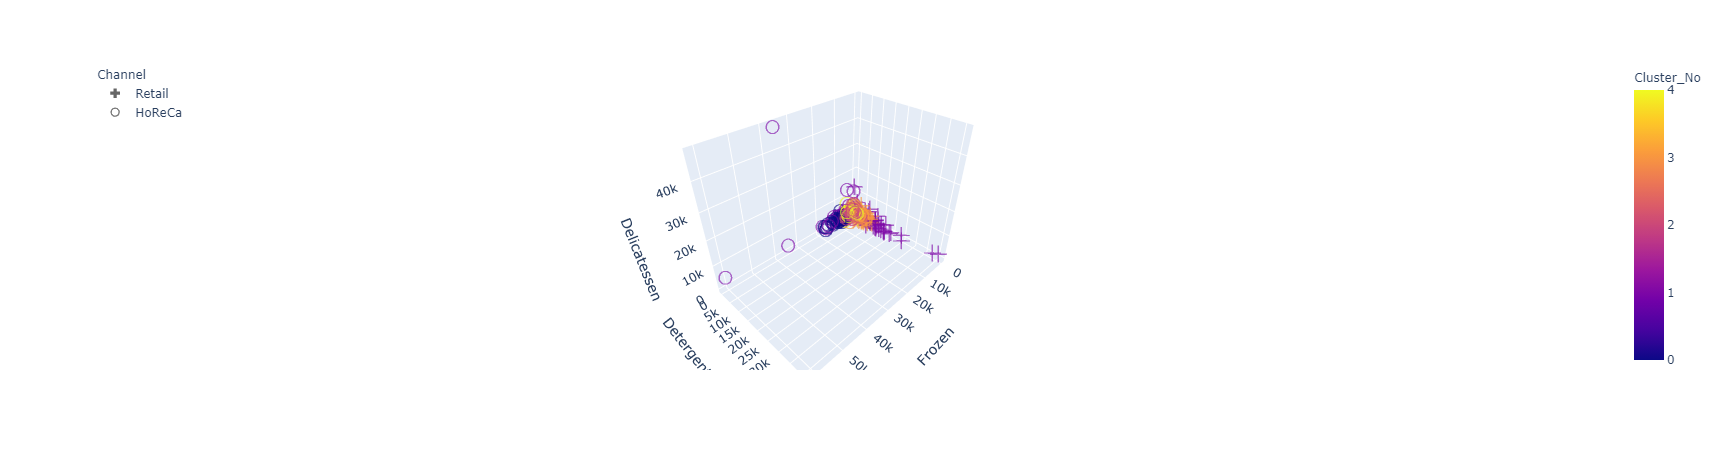

In [31]:
fig = px.scatter_3d(combined, x='Frozen',y='Detergents_Paper',z='Delicatessen',
                   opacity=0.6,symbol='Channel',color = 'Cluster_No')
# specify trace names and symbols in a dict
symbols = {'Retail': 'cross',
           'HoReCa':'circle-open'}

# set all symbols in fig
for i, d in enumerate(fig.data):
    fig.data[i].marker.symbol = symbols[fig.data[i].name]

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

We can see the same pattern in this plot. Nevertheless, I proceed with creating more visualizations to give us a better perspective and, in turn, insights.

In [32]:
combined.groupby(['Cluster_No'])[continuous].mean().style.background_gradient(cmap='viridis')

This plot shows that there are different interesting patterns within each group, especially in group 1. The amount purchased in this group is significant across almost all the continuous features. To see more details, we can expand on the graph with categorical information. 

In [33]:
combined.groupby(['Cluster_No','Channel','Region'])[continuous].mean().style.background_gradient(cmap='viridis')

We can see some clusters has its values concentrated around the categories within either `Channel` or `Region`, such as cluster number 1. Meanwhile, some other clusters has its values distributed more equally across those features.

Now that all the auxiliary visualizations are done, we proceed with arguably the most important graph in this project: the polar plot. This plot is crucial in order to see the characteristics of each cluster with regards to the amount of money its customers spend, respectively. To make the chart, we need to min-max scaling the data first.

In [34]:
from sklearn.preprocessing import MinMaxScaler

# scaling
scaler = MinMaxScaler()
cont_normed = df[continuous].to_numpy()
cont_normed = scaler.fit_transform(cont_normed)

df_normalized = combined.copy(deep=True)
df_normalized[continuous] = cont_normed
# df_normalized[continuous] /= df_normalized[continuous].max()
biggest_cluster = df_normalized.groupby(['Cluster_No']).count().max().max()

df_normalized

Channel Region     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0    Retail  Other  0.112940  0.130727  0.081464  0.003106          0.065427   
1    Retail  Other  0.062899  0.132824  0.103097  0.028548          0.080590   
2    Retail  Other  0.056622  0.119181  0.082790  0.039116          0.086052   
3    HoReCa  Other  0.118254  0.015536  0.045464  0.104842          0.012346   
4    Retail  Other  0.201626  0.072914  0.077552  0.063934          0.043455   
..      ...    ...       ...       ...       ...       ...               ...   
435  HoReCa  Other  0.264829  0.163338  0.172715  0.215469          0.004385   
436  HoReCa  Other  0.349761  0.018736  0.008202  0.073713          0.002205   
437  Retail  Other  0.129543  0.210136  0.325943  0.006771          0.363463   
438  HoReCa  Other  0.091727  0.026224  0.024025  0.016649          0.004042   
439  HoReCa  Other  0.024824  0.022371  0.027022  0.000657          0.011611   

     Delicatessen    kpca_1    kpca_2    kpca_3    kpca_4  Cluster_No  
0        0.027847  0.078374 -0.173115 -0.338646  0.125439           3  
1        0.036984  0.185813 -0.307415 -0.189365  0.244399           3  
2        0.163559  0.341702  0.075048  0.065402  0.055788           1  
3        0.037234 -0.253304  0.250352  0.159350  0.322670           0  
4        0.108093  0.136617  0.375279 -0.206154  0.208622           4  
..            ...       ...       ...       ...       ...         ...  
435      0.045912  0.376162  0.466779  0.244987  0.119531           1  
436      0.048874  0.130231  0.745111 -0.197829 -0.150616           4  
437      0.038882  0.720747  0.122400  0.271172 -0.372950           1  
438      0.044264 -0.352004 -0.033909 -0.078534 -0.070619           2  
439      0.001022 -0.343427 -0.268287  0.101947 -0.254443           2  

[440 rows x 13 columns]

Finally, all we need to do is plotting the data now!

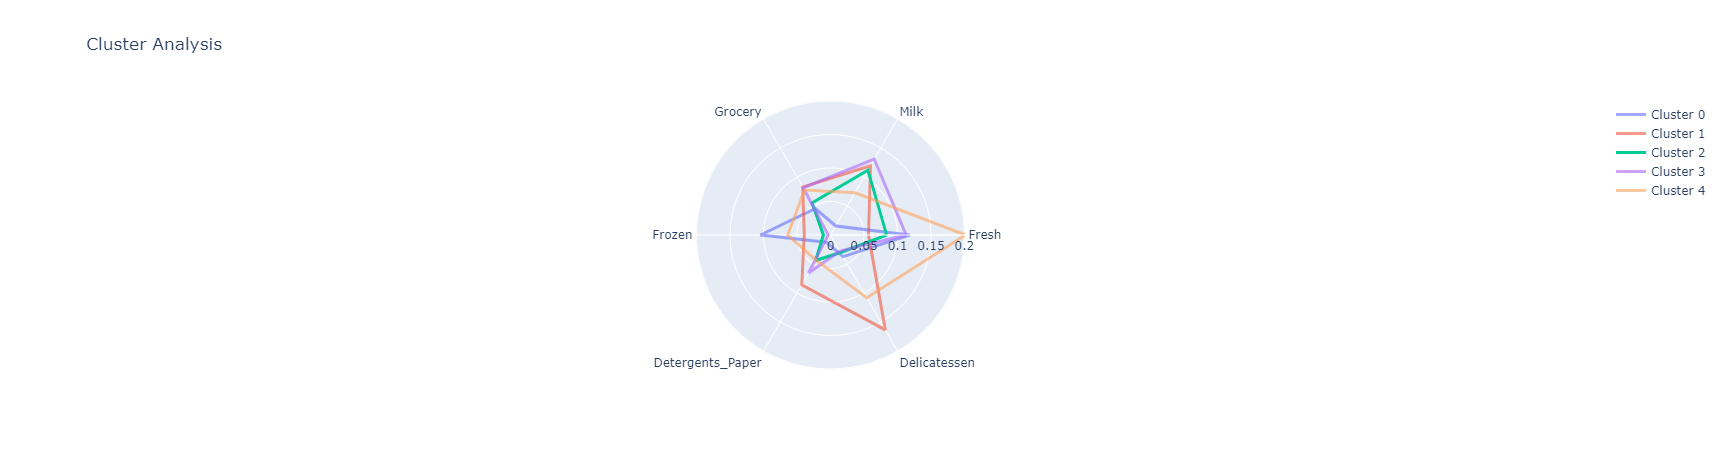

In [35]:
fig = go.Figure()

for cluster in np.unique(clusters):
    
    radii = df_normalized.loc[df_normalized.Cluster_No==cluster, continuous].values[0].tolist()
    thetas = continuous
    
    actual_values = df.loc[df_normalized.Cluster_No==cluster, continuous].values[0].tolist()
    cluster_size = len(df[df_normalized.Cluster_No==cluster])
    fig.add_trace(
        go.Scatterpolar(
            r=radii + radii[:1],
            theta=thetas + thetas[:1],
            mode='lines',
            name=f'Cluster {cluster}',
            text = [f'Mean value: {x}' for x in actual_values + actual_values[:1]],
            line=dict(width=3),
            opacity=np.max([cluster_size/biggest_cluster, 0.6])
        )
    )

fig.update_layout(
    title='Cluster Analysis',
    showlegend=True,
    width=800
)

fig.show()

Voilá! We can see all the characteristics of each cluster now. For example, the first cluster is a group of customers who buy a lot of Fresh products - much more than any other group in fact. Cluster 1 is another interesting grouping, with its member consume considerably more Delicatessen. We can keep going on with this type of analysis with the rest of the clusters. 

All of such information extracted from this will help the business target their offerings and promotions as well as develop customized marketing campaigns. The clusters formed above will act as customer personae that help guiding business decisions. 